# Simple Machine Learning Models on Breast Cancer Data

Use classification technique on the Breast Cancer dataset. \
Data: https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data \
Description: https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names

Specifically, build a decision tree, logistic regression and k-nearest neighbors that predicts the diagnose result based on ten real-valued features (mean, standard error, and "worst" or largest of these features). Explore how well different model perform for several different parameter values. When is overfitting and when is underfitting? Show how you set the model that provides the best predictive performance.


Present a brief overview of your predictive modeling process, explorations, and discuss your results. Make sure you present information about the model “goodness” (possible things to think about: confusion matrix, predictive accuracy, classification error, precision, recall, f-measure).


## Setup

In [1]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, accuracy_score 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

## Load and prepare data

In [2]:
#raw = pd.read_csv('wdbc.data')
raw  = pd.read_csv('data.csv')

After a quick look at the data, it is easy to identify that 'Diagnosis' label is our class label.

In [3]:
# id can't not be classified
X = raw.drop(columns=['id','diagnosis'])
# now as ou know our diagnosis column is a object type so we can map it to integer value
y=raw['diagnosis'].map({'M':1,'B':0})

### Correlation

Feature Correlation:



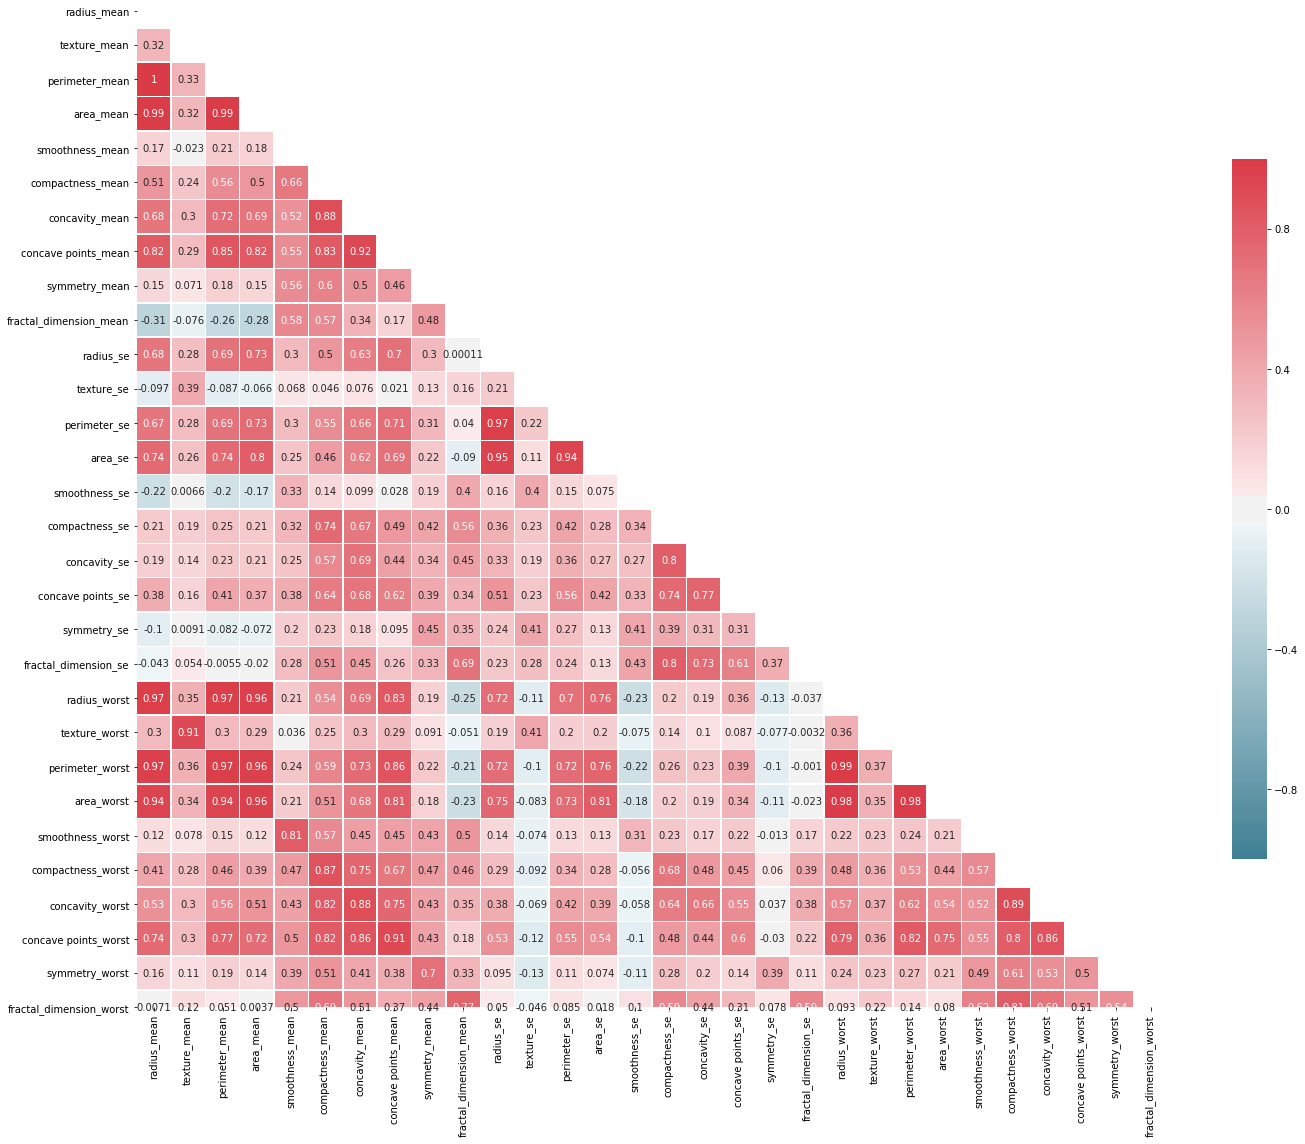

In [4]:
print("Feature Correlation:\n")

f, ax = plt.subplots(figsize=(20, 20))

# Mask for the upper triangle
mask = np.zeros_like(X.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Define custom colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(X.corr(), mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.tight_layout()

As it can be seen in map heat figure:
- radius_mean, perimeter_mean and area_mean, radius_worst, perimeter_worst, area_worst, radius_se, perimeter_se and area_se are correlated with each other so we will use only **area_mean**.
- Compactness_mean, concavity_mean and concave points_mean, Compactness_worst, concavity_worst and concave points_worst, Compactness_se, concavity_se and concave points_se, are correlated with each other. I only choose **concavity_mean**. 
- symmetry_mean, symmetry_worst are correlated, choose **symmetry_mean**.
- fractal_dimension_mean, fractal_dimension_worst are correlated, choose *fractal_dimension_mean*.
- texture_mean and texture_worst are correlated and I use texture_mean. 
- smoothness_mean, smoothness_se and smoothness_worst are correlated. I use smoothness_worst.

## Initial Feature Selection
__1) retain only features that are not correlated_ X_retained__

In [5]:
X_retained = X.drop(columns=['radius_mean','perimeter_mean', 'radius_worst', 'perimeter_worst', 'area_worst', 'radius_se','perimeter_se','area_se',
                     'smoothness_mean','smoothness_se',
                     'compactness_mean', 'concave points_mean', 'compactness_worst', 'concave points_worst', 'concavity_worst', 
             'symmetry_worst','compactness_se','concave points_se','concavity_se',
             'fractal_dimension_worst',             
             'texture_worst'])

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_retained, y, test_size=0.25)
print('\n Feature Names:', X.columns.values, "\n")


 Feature Names: ['radius_mean' 'texture_mean' 'perimeter_mean' 'area_mean'
 'smoothness_mean' 'compactness_mean' 'concavity_mean'
 'concave points_mean' 'symmetry_mean' 'fractal_dimension_mean'
 'radius_se' 'texture_se' 'perimeter_se' 'area_se' 'smoothness_se'
 'compactness_se' 'concavity_se' 'concave points_se' 'symmetry_se'
 'fractal_dimension_se' 'radius_worst' 'texture_worst' 'perimeter_worst'
 'area_worst' 'smoothness_worst' 'compactness_worst' 'concavity_worst'
 'concave points_worst' 'symmetry_worst' 'fractal_dimension_worst'] 



Let's take a look at the correlation matrix once again, this time created with our trimmed-down set of variables.

Feature Correlation:



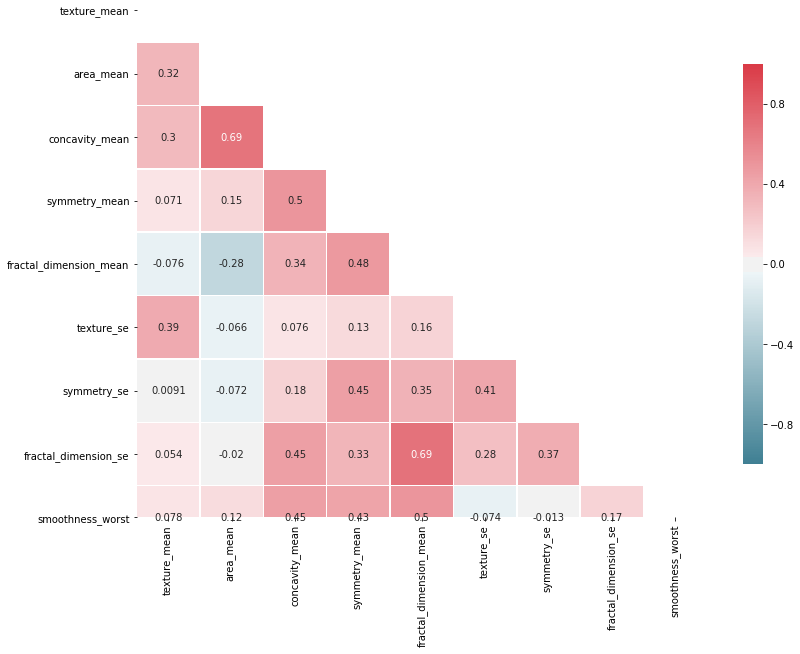

In [6]:
# Draw the heatmap again, with the new correlation matrix
print("Feature Correlation:\n")
f, ax = plt.subplots(figsize=(12, 12))

mask = np.zeros_like(X_retained.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(X_retained.corr(), mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.tight_layout()

## Data Scale and Split

In [7]:
# normalizing data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X_retained)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1000, stratify=y)

## Decision tree

### Hyper parameter selection

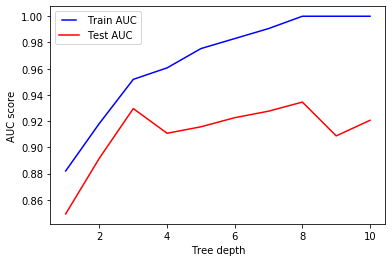

In [8]:
from sklearn import tree
from sklearn.metrics import roc_curve, auc

#----------------- AUC plot with different max depth hyper setting
max_depths = np.linspace(1, 10, 10, endpoint=True)

train_results = []
test_results = []
training_accuracy = []
test_accuracy = []

for max_depth in max_depths:
    dtree = tree.DecisionTreeClassifier(max_depth=max_depth)
    dtree.fit(X_train, y_train)
    train_pred = dtree.predict(X_train)
    
    # Add auc score to previous train results
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)   
    
    # Add auc score to previous test results
    train_results.append(roc_auc)
    y_pred = dtree.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)    
    test_results.append(roc_auc)
    
    training_accuracy.append(dtree.score(X_train, y_train))
    test_accuracy.append(dtree.score(X_test, y_test))
    
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_depths, train_results, color = 'blue', label='Train AUC')
line2, = plt.plot(max_depths, test_results, color = 'red',label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

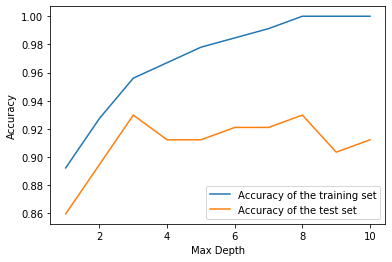

In [9]:
#----------------- Decision Tree Accuracy plot with different max depth hyper setting
plt.plot(max_depths,training_accuracy, label='Accuracy of the training set')
plt.plot(max_depths,test_accuracy, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Max Depth')
plt.legend()

By having larger max_depth(>=3), we overfit the model into training data, so the accuracy for training set become 
but the accuracy for test set decrease.

From AUC and Accuracy plot, we could conclude that a potential reasonable max-depth is 3.

However,other parameters than can work with:
- min_samples_leaf, max_sample_leaf
- max_leaf_node

by looking at plot, best result accurs when max_depth is 3

### Model Performance 

In [10]:
clf_tree = tree.DecisionTreeClassifier(max_depth=3)
clf_tree = clf_tree.fit(X_train, y_train)

y_predict_tree = clf_tree.predict(X_test)
print('Accuracy of Decision Tree classifier on reduced test set: {:.4f}'.format(accuracy_score(y_test, y_predict_tree)))

Accuracy of Decision Tree classifier on reduced test set: 0.9211


In [11]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf_tree, X_scaled, y, cv=10)
print(scores)
print('cv_scores mean:{0:.4f}'.format(scores.mean()))

[0.9137931  0.86206897 0.92982456 0.92982456 0.92982456 0.92982456
 0.94736842 0.94642857 0.96428571 0.98214286]
cv_scores mean:0.9335


In [13]:
#----------------- Decision Tree Confusion Matrix
pd.DataFrame(
    confusion_matrix(y_test, y_predict_tree),
    columns=['Predicted Malignant', 'Predicted Benign'],
    index=['True Malignant', 'True Benign'])

,Predicted Malignant,Predicted Benign
True Malignant,66,6
True Benign,3,39


Let's look at the decision tree diagram 

/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


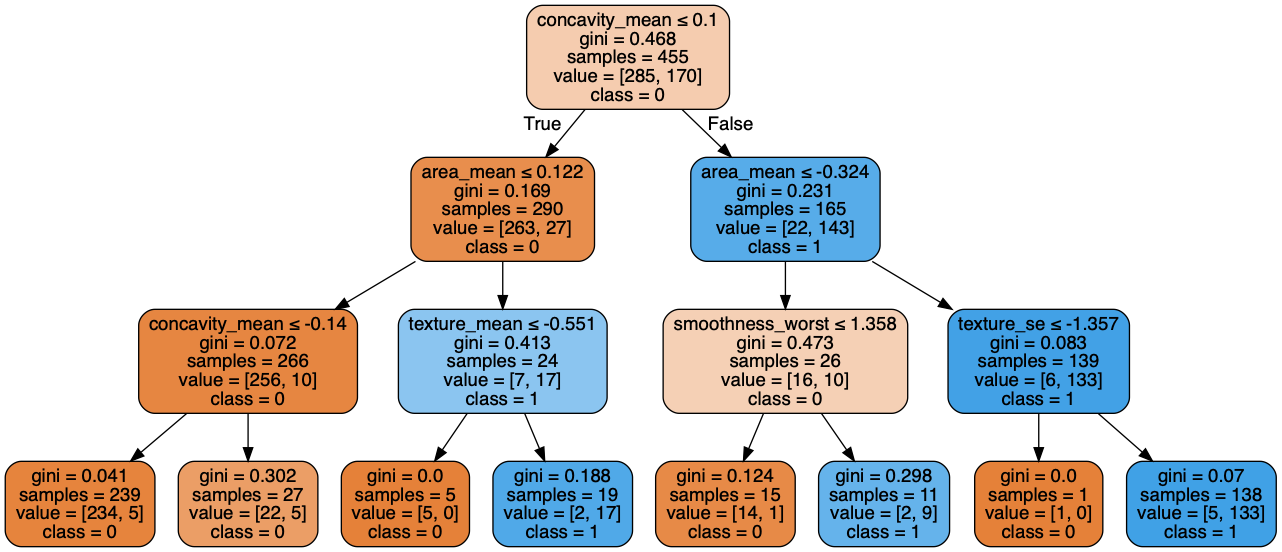

In [14]:
#----------------- Decision Tree Diagram with the max depth of 5
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf_tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X_retained.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Breast cancer attributes.png')
Image(graph.create_png())

## K-NN

### Model with Holdout

In [15]:
from sklearn import neighbors

# specify the desired number of neighbors for our kNN classifier
n_neighbors = 3

clf2 = neighbors.KNeighborsClassifier(n_neighbors)
clf2 = clf2.fit(X_train, y_train)

y_predict2 = clf2.predict(X_test)
clf2.score(X_test,y_test)

0.9736842105263158

### Hypertuning using GridSearchCV

In [16]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

#create new a knn model
knn2 = neighbors.KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=10)
#fit model to data
knn_gscv.fit(X_scaled, y)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [17]:
#check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 5}

In [18]:
#check mean score for the top performing value of n_neighbors
knn_gscv.best_score_

0.9490333919156415

### Model Performance

In [19]:
from sklearn.model_selection import cross_val_score

#create a new KNN model
knn_cv = neighbors.KNeighborsClassifier(n_neighbors=5)

cv_scores = cross_val_score(knn_cv, X_scaled, y, cv=10)

#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{0:.4f}'.format(np.mean(cv_scores)))

[0.98275862 0.93103448 0.96491228 0.94736842 0.98245614 0.92982456
 0.94736842 1.         0.91071429 0.89285714]
cv_scores mean:0.9489


In [20]:
from sklearn import neighbors
from sklearn.model_selection import cross_val_score

#create a new KNN model
n_neighbors = 5
clf_knn = neighbors.KNeighborsClassifier(n_neighbors)

## Train the model (fit the data)
clf_knn = clf_knn.fit(X_train, y_train)
y_predict_knn = clf_knn.predict(X_test)

print('holdout score:{0:.4f}'.format(clf_knn.score(X_test,y_test)))


cv_scores = cross_val_score(clf_knn, X_scaled, y, cv=10)

print(cv_scores)
print('Cross validation scores mean:{0:.4f}'.format(np.mean(cv_scores)))

holdout score:0.9737
[0.98275862 0.93103448 0.96491228 0.94736842 0.98245614 0.92982456
 0.94736842 1.         0.91071429 0.89285714]
Cross validation scores mean:0.9489


In [21]:
#----------------- KNN Confusion Matrix

pd.DataFrame(
    confusion_matrix(y_test, y_predict_knn),
    columns=['Predicted Malignant', 'Predicted Benign'],
    index=['True Malignant', 'True Benign'])

,Predicted Malignant,Predicted Benign
True Malignant,71,1
True Benign,2,40


## Logistic Regression

### Fine tuning model

In [38]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
#C=[0.001,.009,0.01,.09,1,5,10,25,100]
C = np.logspace(-5, 8, 15) 

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

logistic = linear_model.LogisticRegression(solver='liblinear')
lr_gscv = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)

# Fit grid search
lr_gscv.fit(X_train, y_train)

print('Best Penalty:', lr_gscv.best_params_['penalty'])
print('Best C:', lr_gscv.best_params_['C'])

Best Penalty: l2
Best C: 0.4393970560760795


### Model Performance

In [39]:
from sklearn.linear_model import LogisticRegression

clf_lr=LogisticRegression(C=0.439,penalty='l2')
clf_lr.fit(X_train,y_train)

y_predict_lr = clf_lr.predict(X_test)

print("test accuracy: {} ".format(clf_lr.score(X_test, y_test)))
print("train accuracy: {} ".format(clf_lr.score(X_train, y_train)))

test accuracy: 0.9912280701754386 
train accuracy: 0.9582417582417583 


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [40]:
#----------------- Decision Tree Confusion Matrix
pd.DataFrame(
    confusion_matrix(y_test, y_predict_lr),
    columns=['Predicted Malignant', 'Predicted Benign'],
    index=['True Malignant', 'True Benign']
)

,Predicted Malignant,Predicted Benign
True Malignant,72,0
True Benign,1,41


##  Model Evaluation and Conclusion

After fitting three classifiers, namely decision tree, KNN and logistic regression algrithom, their performances metrix is as following

In [41]:
from sklearn.metrics import precision_recall_fscore_support

matrix = pd.DataFrame(
    [list(precision_recall_fscore_support(y_test, y_predict_tree, average='binary')),
    list(precision_recall_fscore_support(y_test, y_predict_knn, average='binary')),
    list(precision_recall_fscore_support(y_test, y_predict_lr, average='binary'))],
    columns = ['precision','recall','Fscore','support'],
    index  = ['decision tree','knn','logistic regression'])
matrix = matrix.iloc[:,:-1]
matrix['accuracy'] =[scores.mean(),cv_scores.mean(),clf_lr.score(X_test, y_test)]

matrix

,precision,recall,Fscore,accuracy
decision tree,0.866667,0.928571,0.896552,0.933539
knn,0.975610,0.952381,0.963855,0.948929
logistic regression,1.000000,0.976190,0.987952,0.991228



Conclusion:  
In this approach, I used K-Fold Cross-Validation to evaluate performance of each model by handling the variance problem of the result set. To identify the best algorithm and best parameters, Grid Search algorithm comes into play on each model.

__As we can see, logistic regression has the highest score across precision, recall, accuracy and Fscore. Also, from three confusion matrix, logistic regression also capture most 'ground true malignant' and 'ground true benign' conditions compared to decision tree and knn methods.__  

__Therefore, in this case, we choose logistic regreesion with C parameter of 0.439 and regularization method of 'Ridge Regression'.__

---End---